In [15]:
from xai import *
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import os
from tqdm import tqdm

In [16]:
save_folder = "./images/mnist-vanilla-shap-explanation"
samples_path = "MNIST/samples"
algorithms = [("permutation", 50_000), ("kernel", None), ("deep", None), ("gradient", None)]
latent_dim = 8
rows = 10
columns = 12

In [17]:
try:
    mnist: MNIST[Literal[8]] = MNIST.load("git-ignore/mnist.model")
except FileNotFoundError:
    mnist = MNIST(
        latent_shape=(latent_dim,), 
        hidden_layers=2, 
        classifier_head_output_activation="Softmax",
        ) 
    
    mnist.fit_autoencoder(
        epochs=10_000,
        batch_size=256,
        loss_criterion="MSELoss",
        early_stop_cont=750,
        verbose=True,
        info="Mnist autoencoder train"
    )

    mnist.fit_classifier_head(
        epochs=10_000,
        batch_size=256,
        early_stop_cont=750,
        verbose=True,
        info="Mnist classifier-head train"
    )

    mnist.save("git-ignore/mnist.model")
    

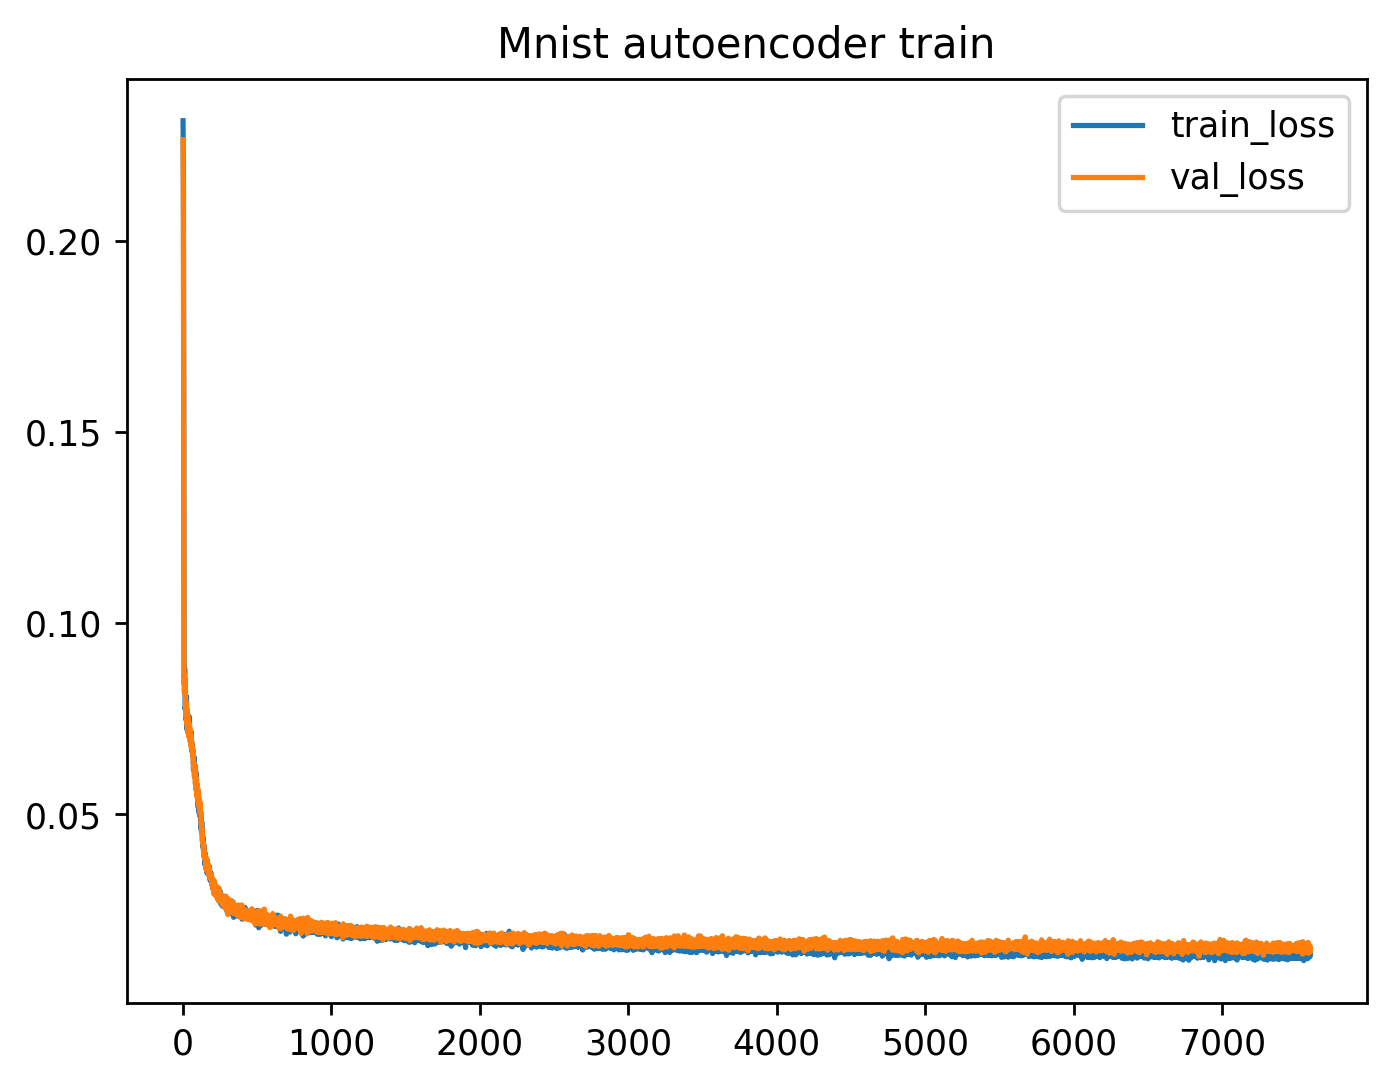

In [18]:
mnist.autoencoder.train_history.figure("Mnist autoencoder train")

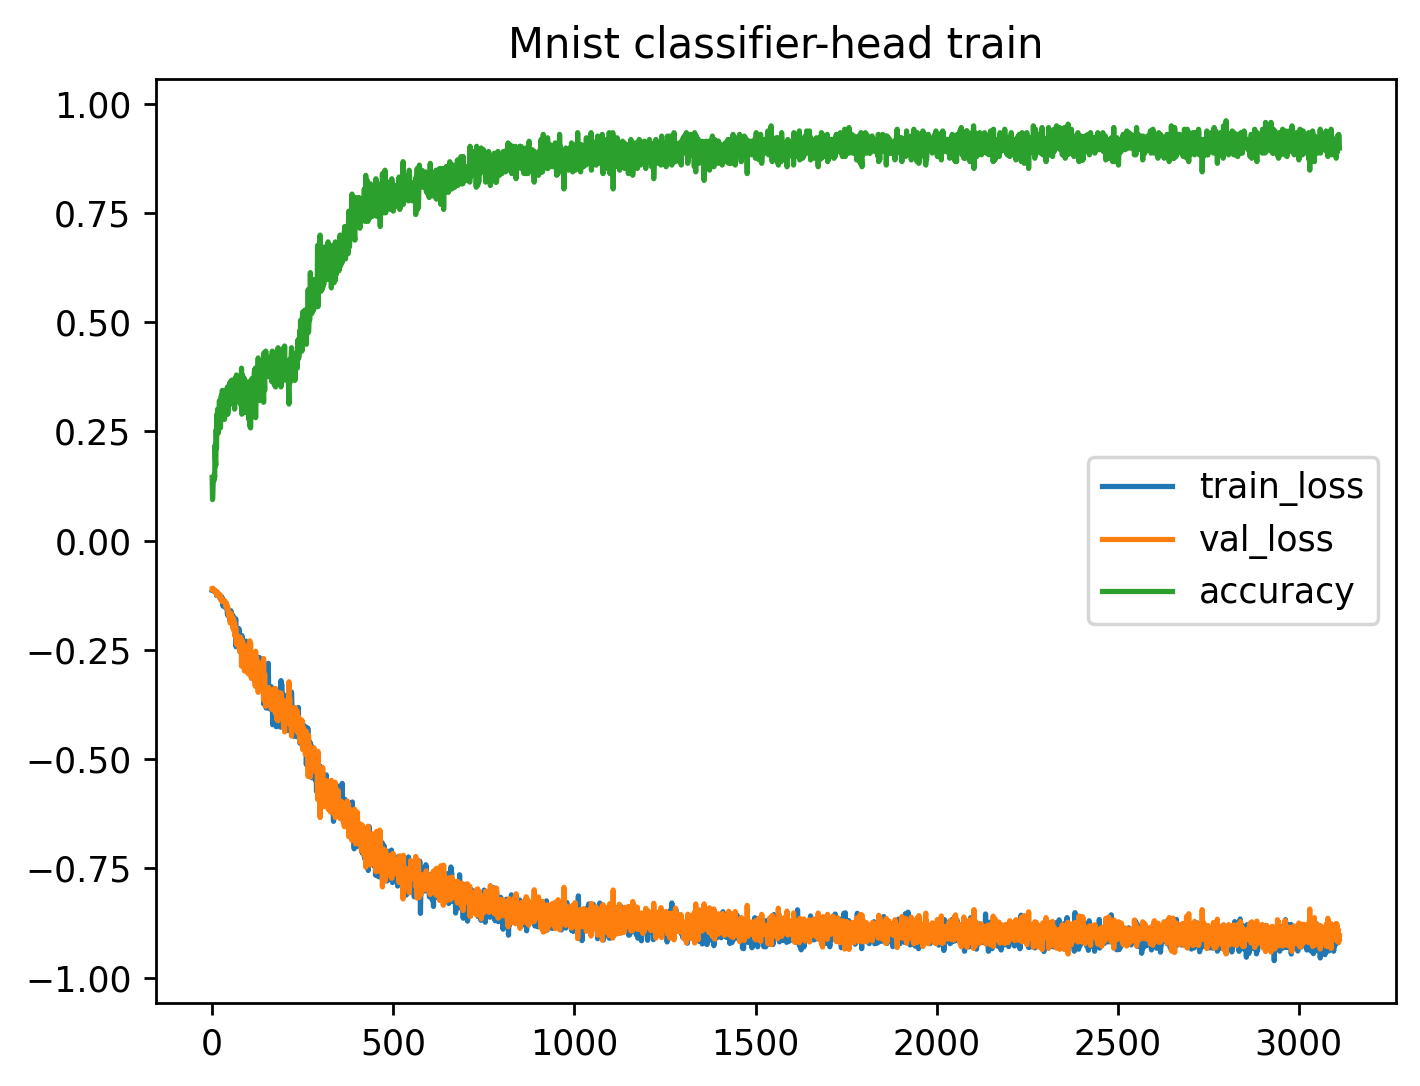

In [19]:
mnist.classifier_head.train_history.figure("Mnist classifier-head train")

In [20]:
try:
    os.mkdir(save_folder)
except:
    pass

for algorithm,evals in algorithms:
    try:
        os.mkdir(f"{save_folder}/{algorithm}")
    except:
        pass

try:
    samples = Stream.load(samples_path, Tuple[torch.Tensor,torch.Tensor]).list()
except:
    samples: List[Tuple[torch.Tensor,torch.Tensor]] = []
    for i in range(rows):
        samples.append(mnist.get_sample(digit=i))

    Stream(samples).save(samples_path)

PermutationExplainer:   0%|          | 0/10 [00:00<?, ?it/s]

PermutationExplainer explainer: 2it [00:42, 42.04s/it]               
PermutationExplainer explainer: 2it [00:30, 30.84s/it]               
PermutationExplainer explainer: 2it [00:37, 37.24s/it]               
PermutationExplainer explainer: 2it [00:29, 29.84s/it]               
PermutationExplainer explainer: 2it [00:29, 29.18s/it]               
PermutationExplainer explainer: 2it [00:31, 31.08s/it]               
PermutationExplainer explainer: 2it [00:30, 30.15s/it]               
PermutationExplainer explainer: 2it [00:27, 27.28s/it]               
PermutationExplainer explainer: 2it [00:29, 29.19s/it]               
PermutationExplainer explainer: 2it [00:28, 28.77s/it]               
KernelExplainer:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

KernelExplainer:  10%|█         | 1/10 [00:52<07:55, 52.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

KernelExplainer:  20%|██        | 2/10 [01:17<04:50, 36.28s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

KernelExplainer:  30%|███       | 3/10 [01:34<03:10, 27.24s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

KernelExplainer:  40%|████      | 4/10 [01:51<02:19, 23.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

KernelExplainer:  50%|█████     | 5/10 [02:07<01:43, 20.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

KernelExplainer:  60%|██████    | 6/10 [02:29<01:24, 21.10s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

KernelExplainer:  70%|███████   | 7/10 [02:49<01:02, 20.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

KernelExplainer:  80%|████████  | 8/10 [03:19<00:47, 23.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

KernelExplainer:  90%|█████████ | 9/10 [03:50<00:26, 26.06s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

DeepExplainer:   0%|          | 0/10 [00:00<?, ?it/s]unrecognized nn.Module: Lambda
CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
GradientExplainer: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


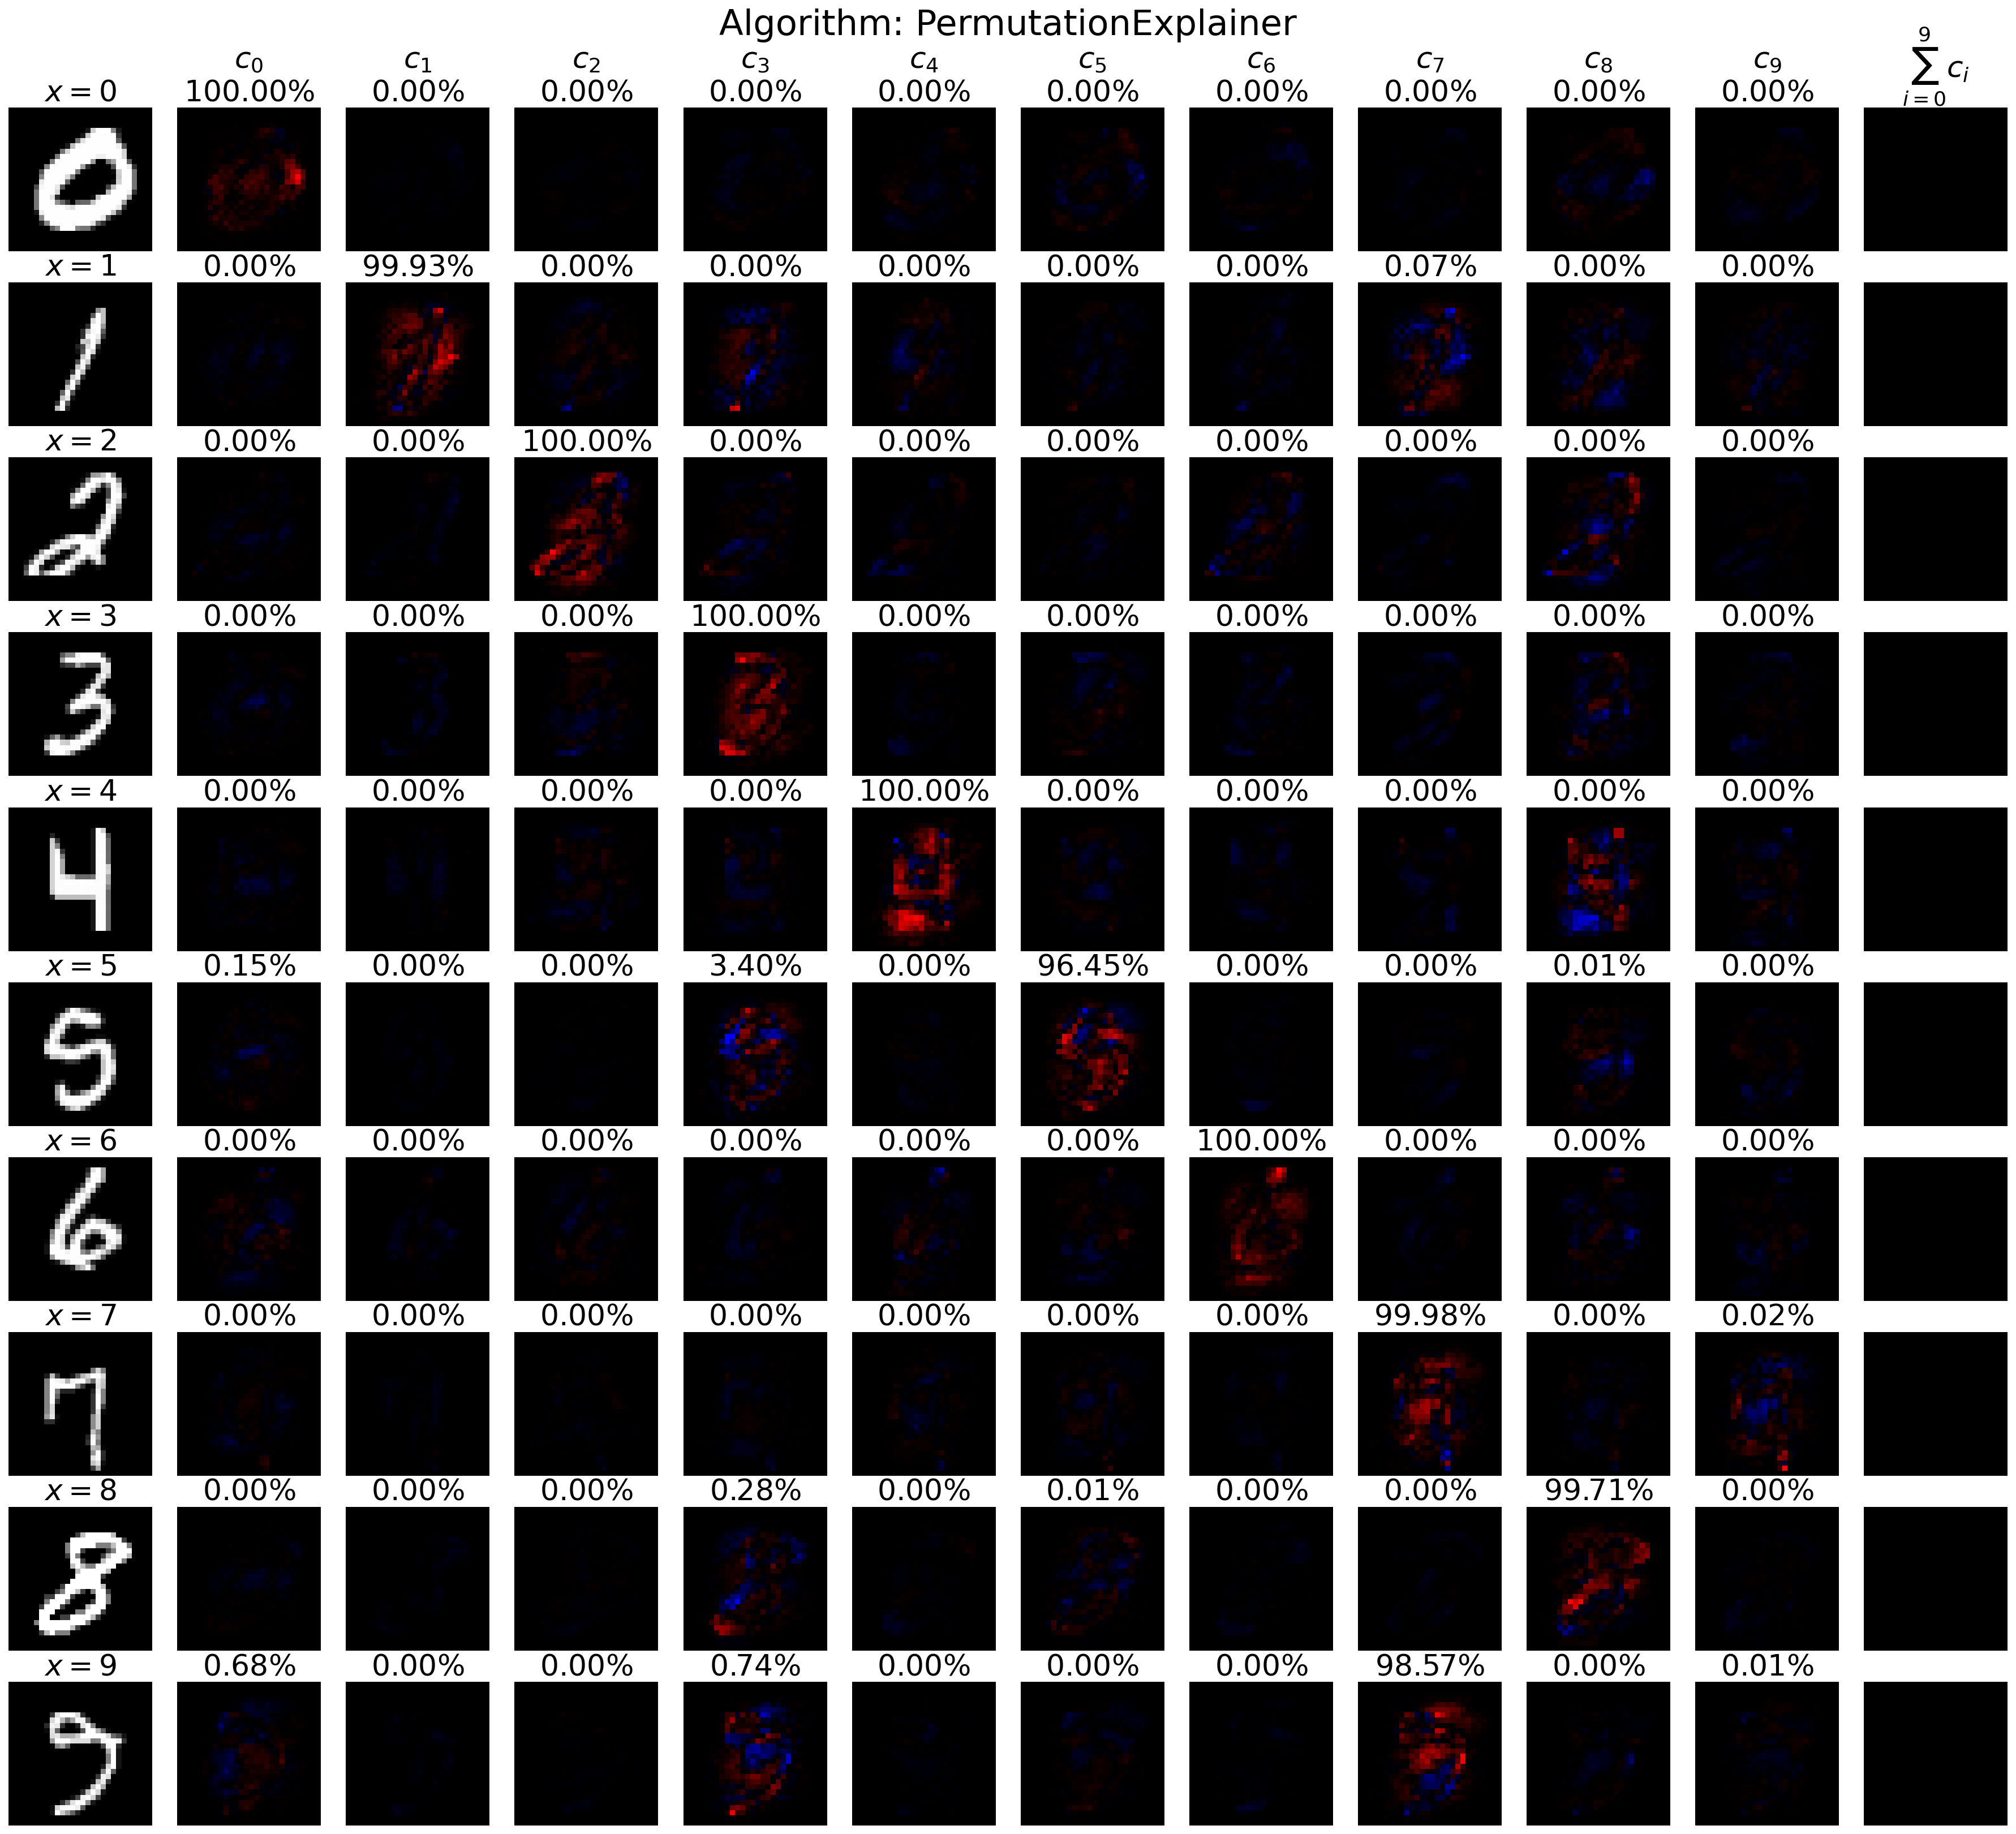

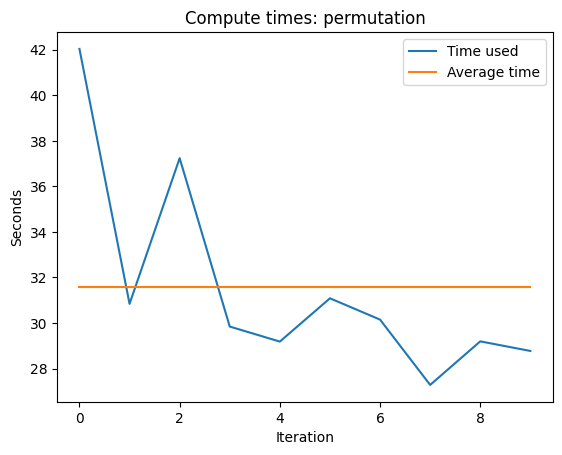

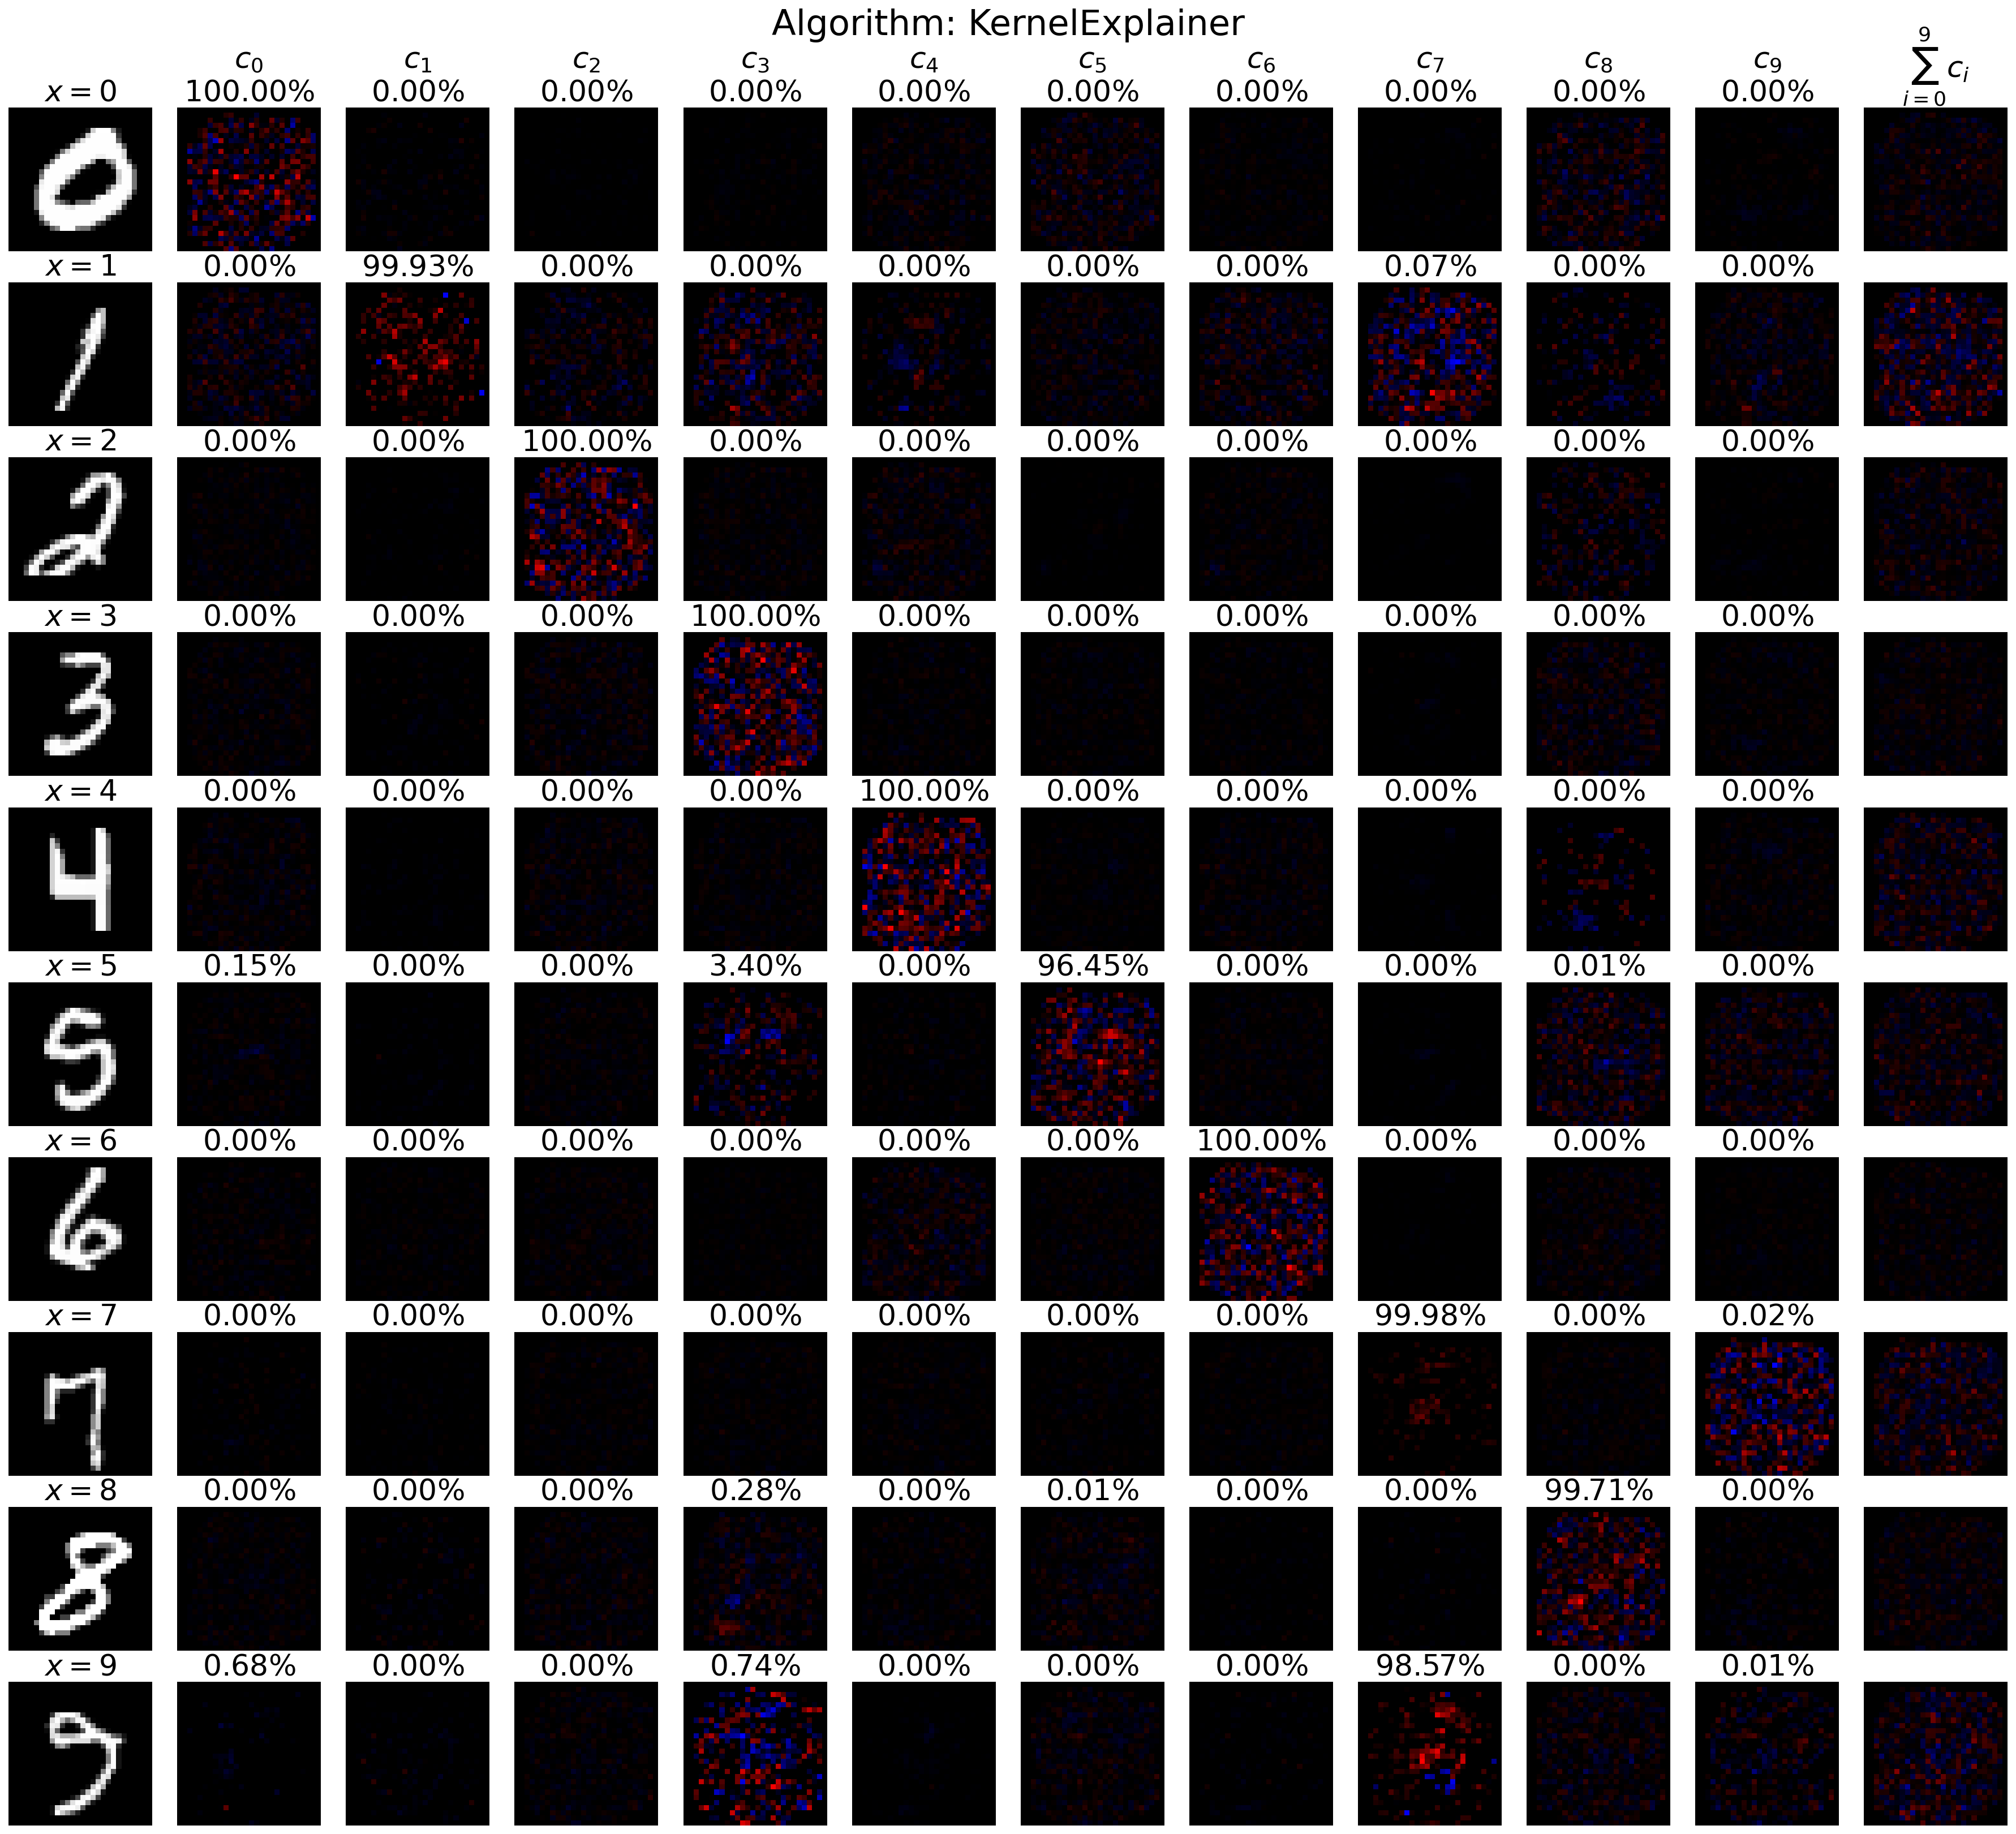

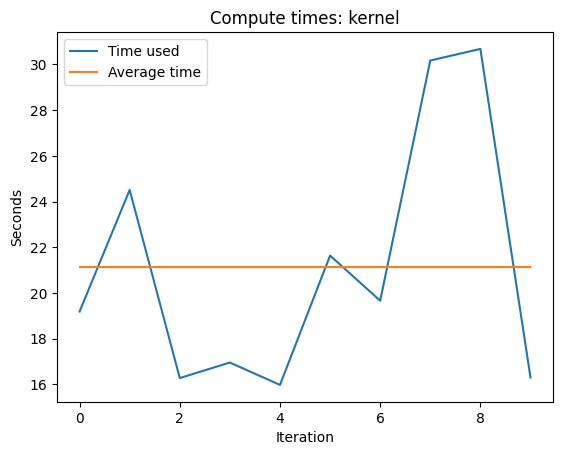

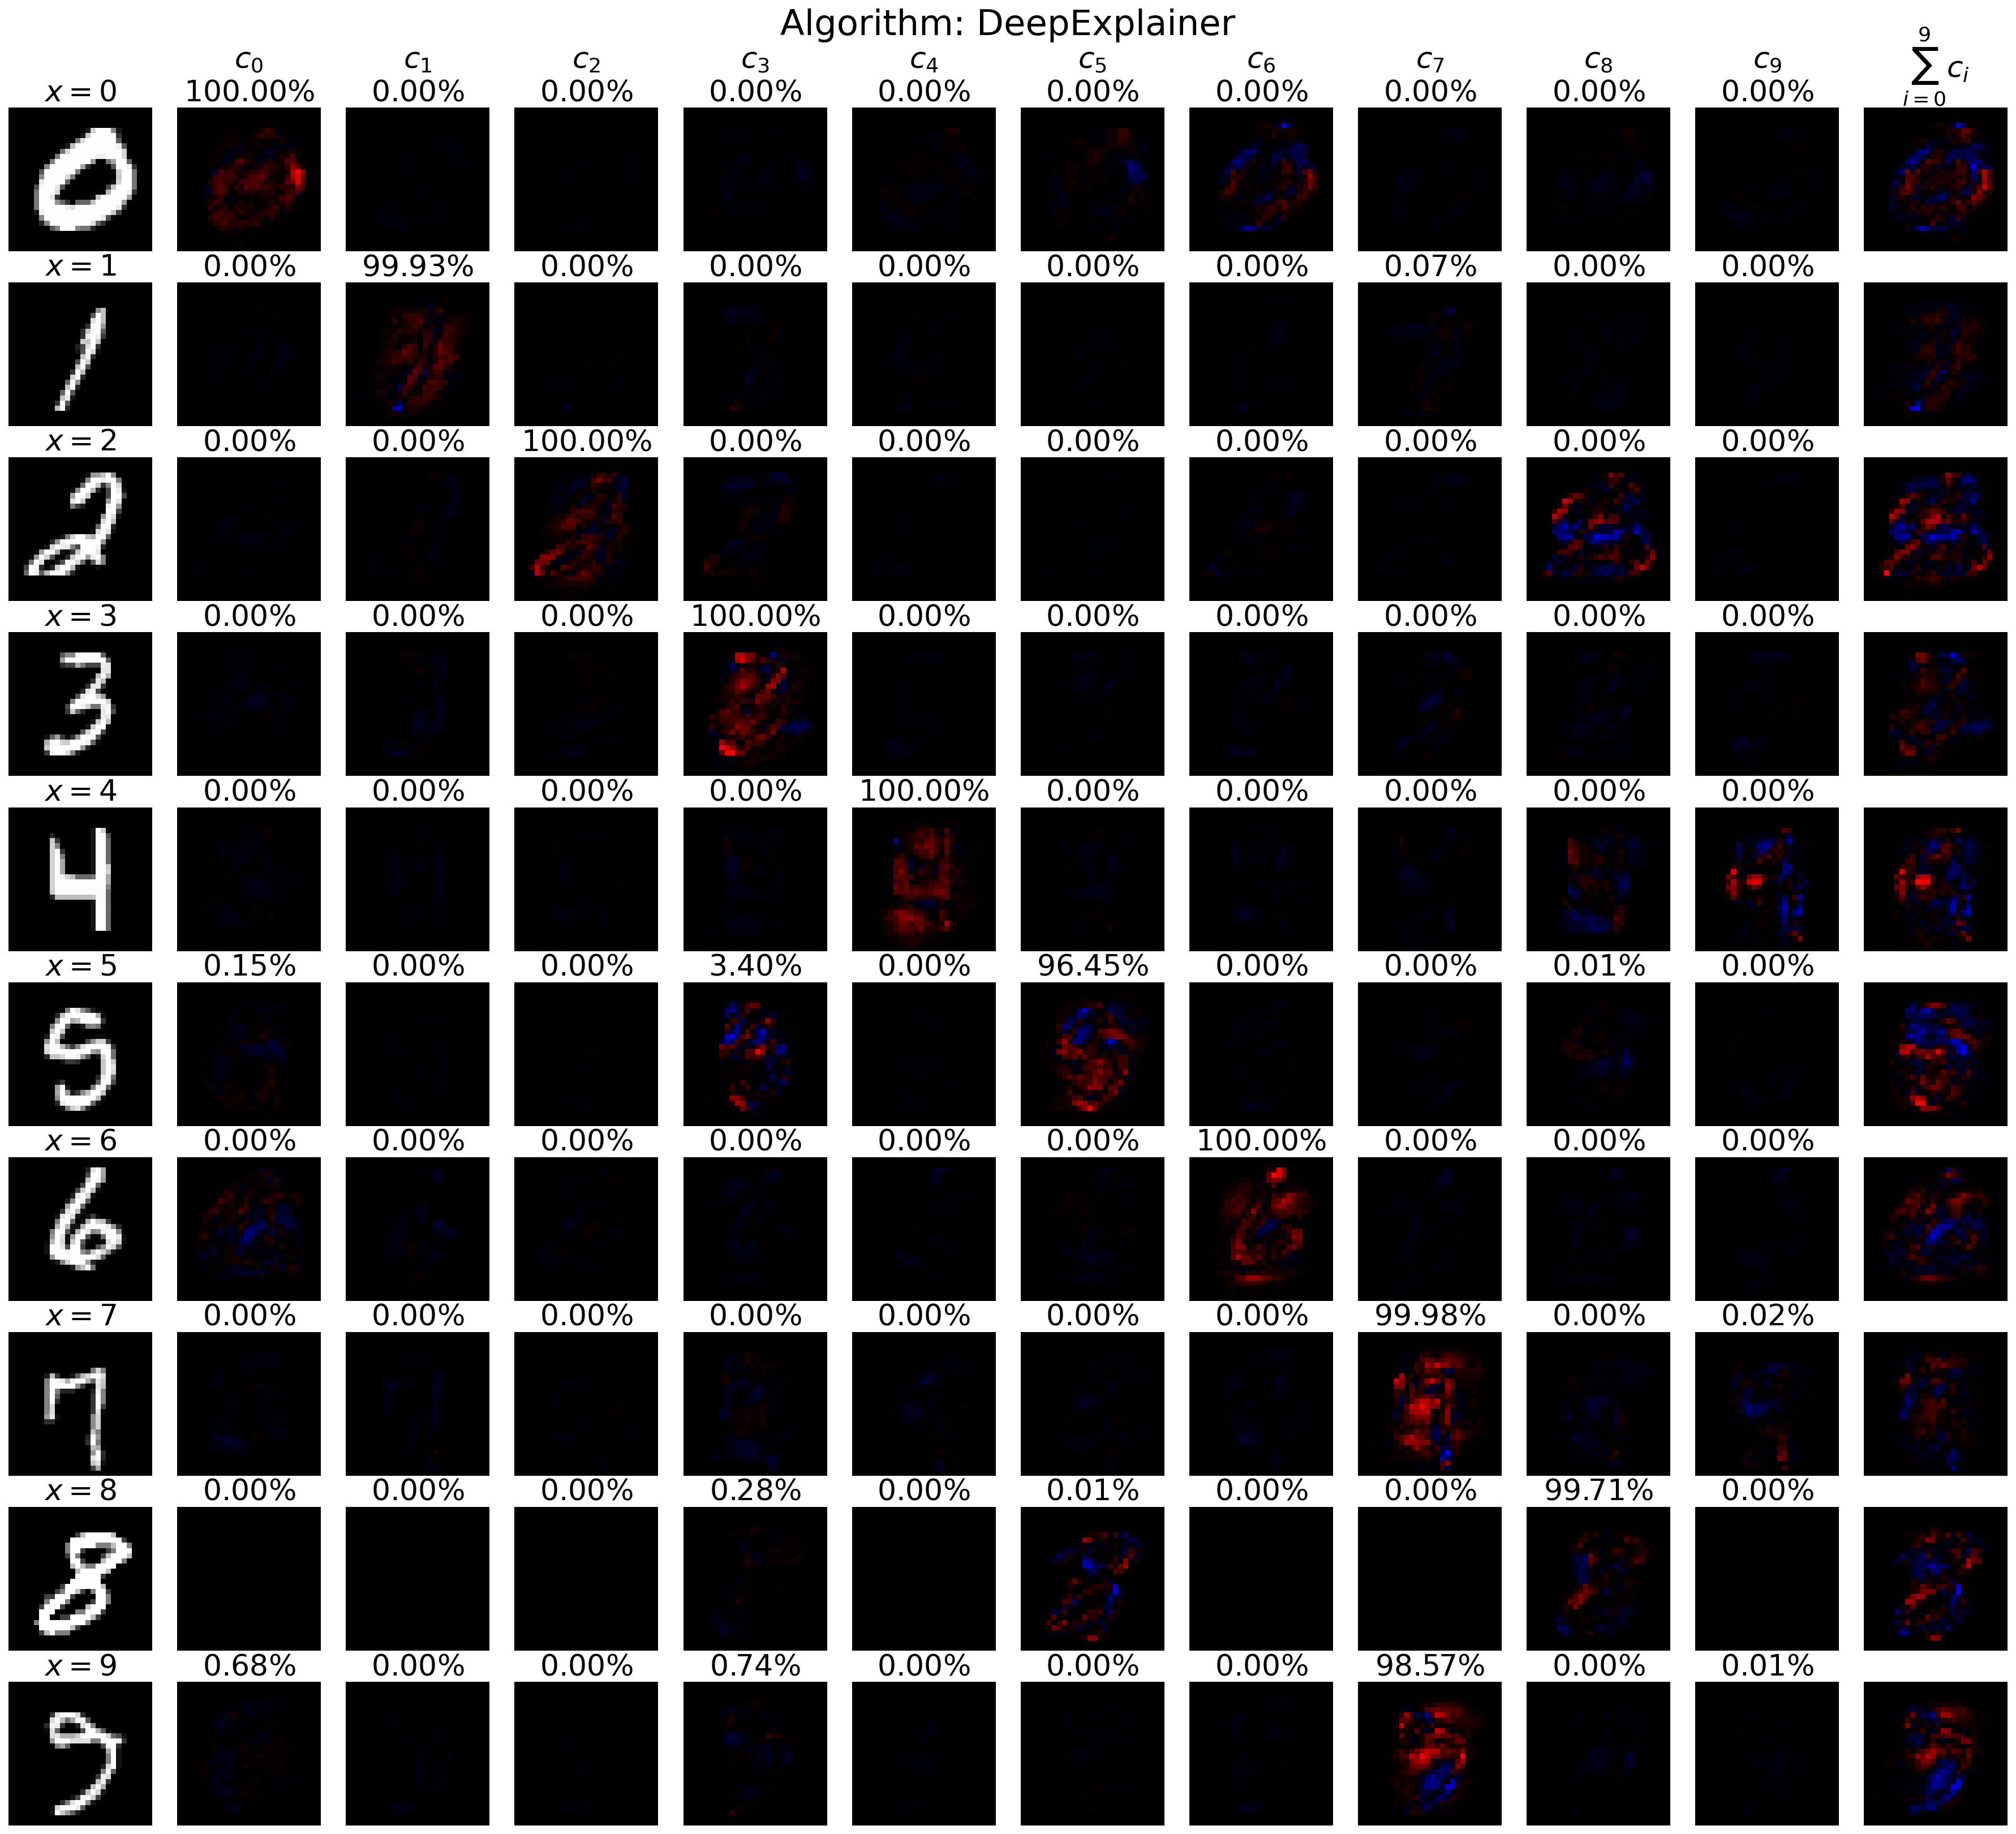

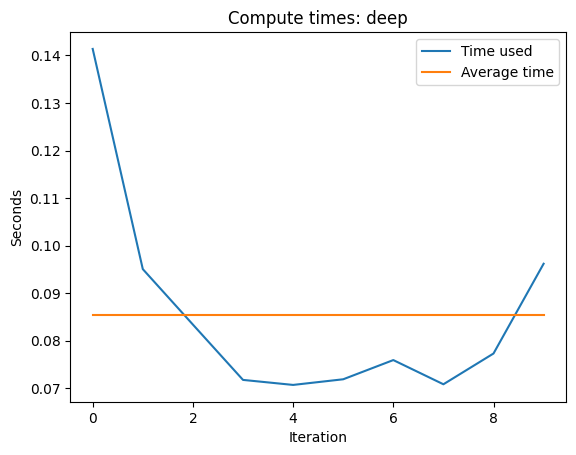

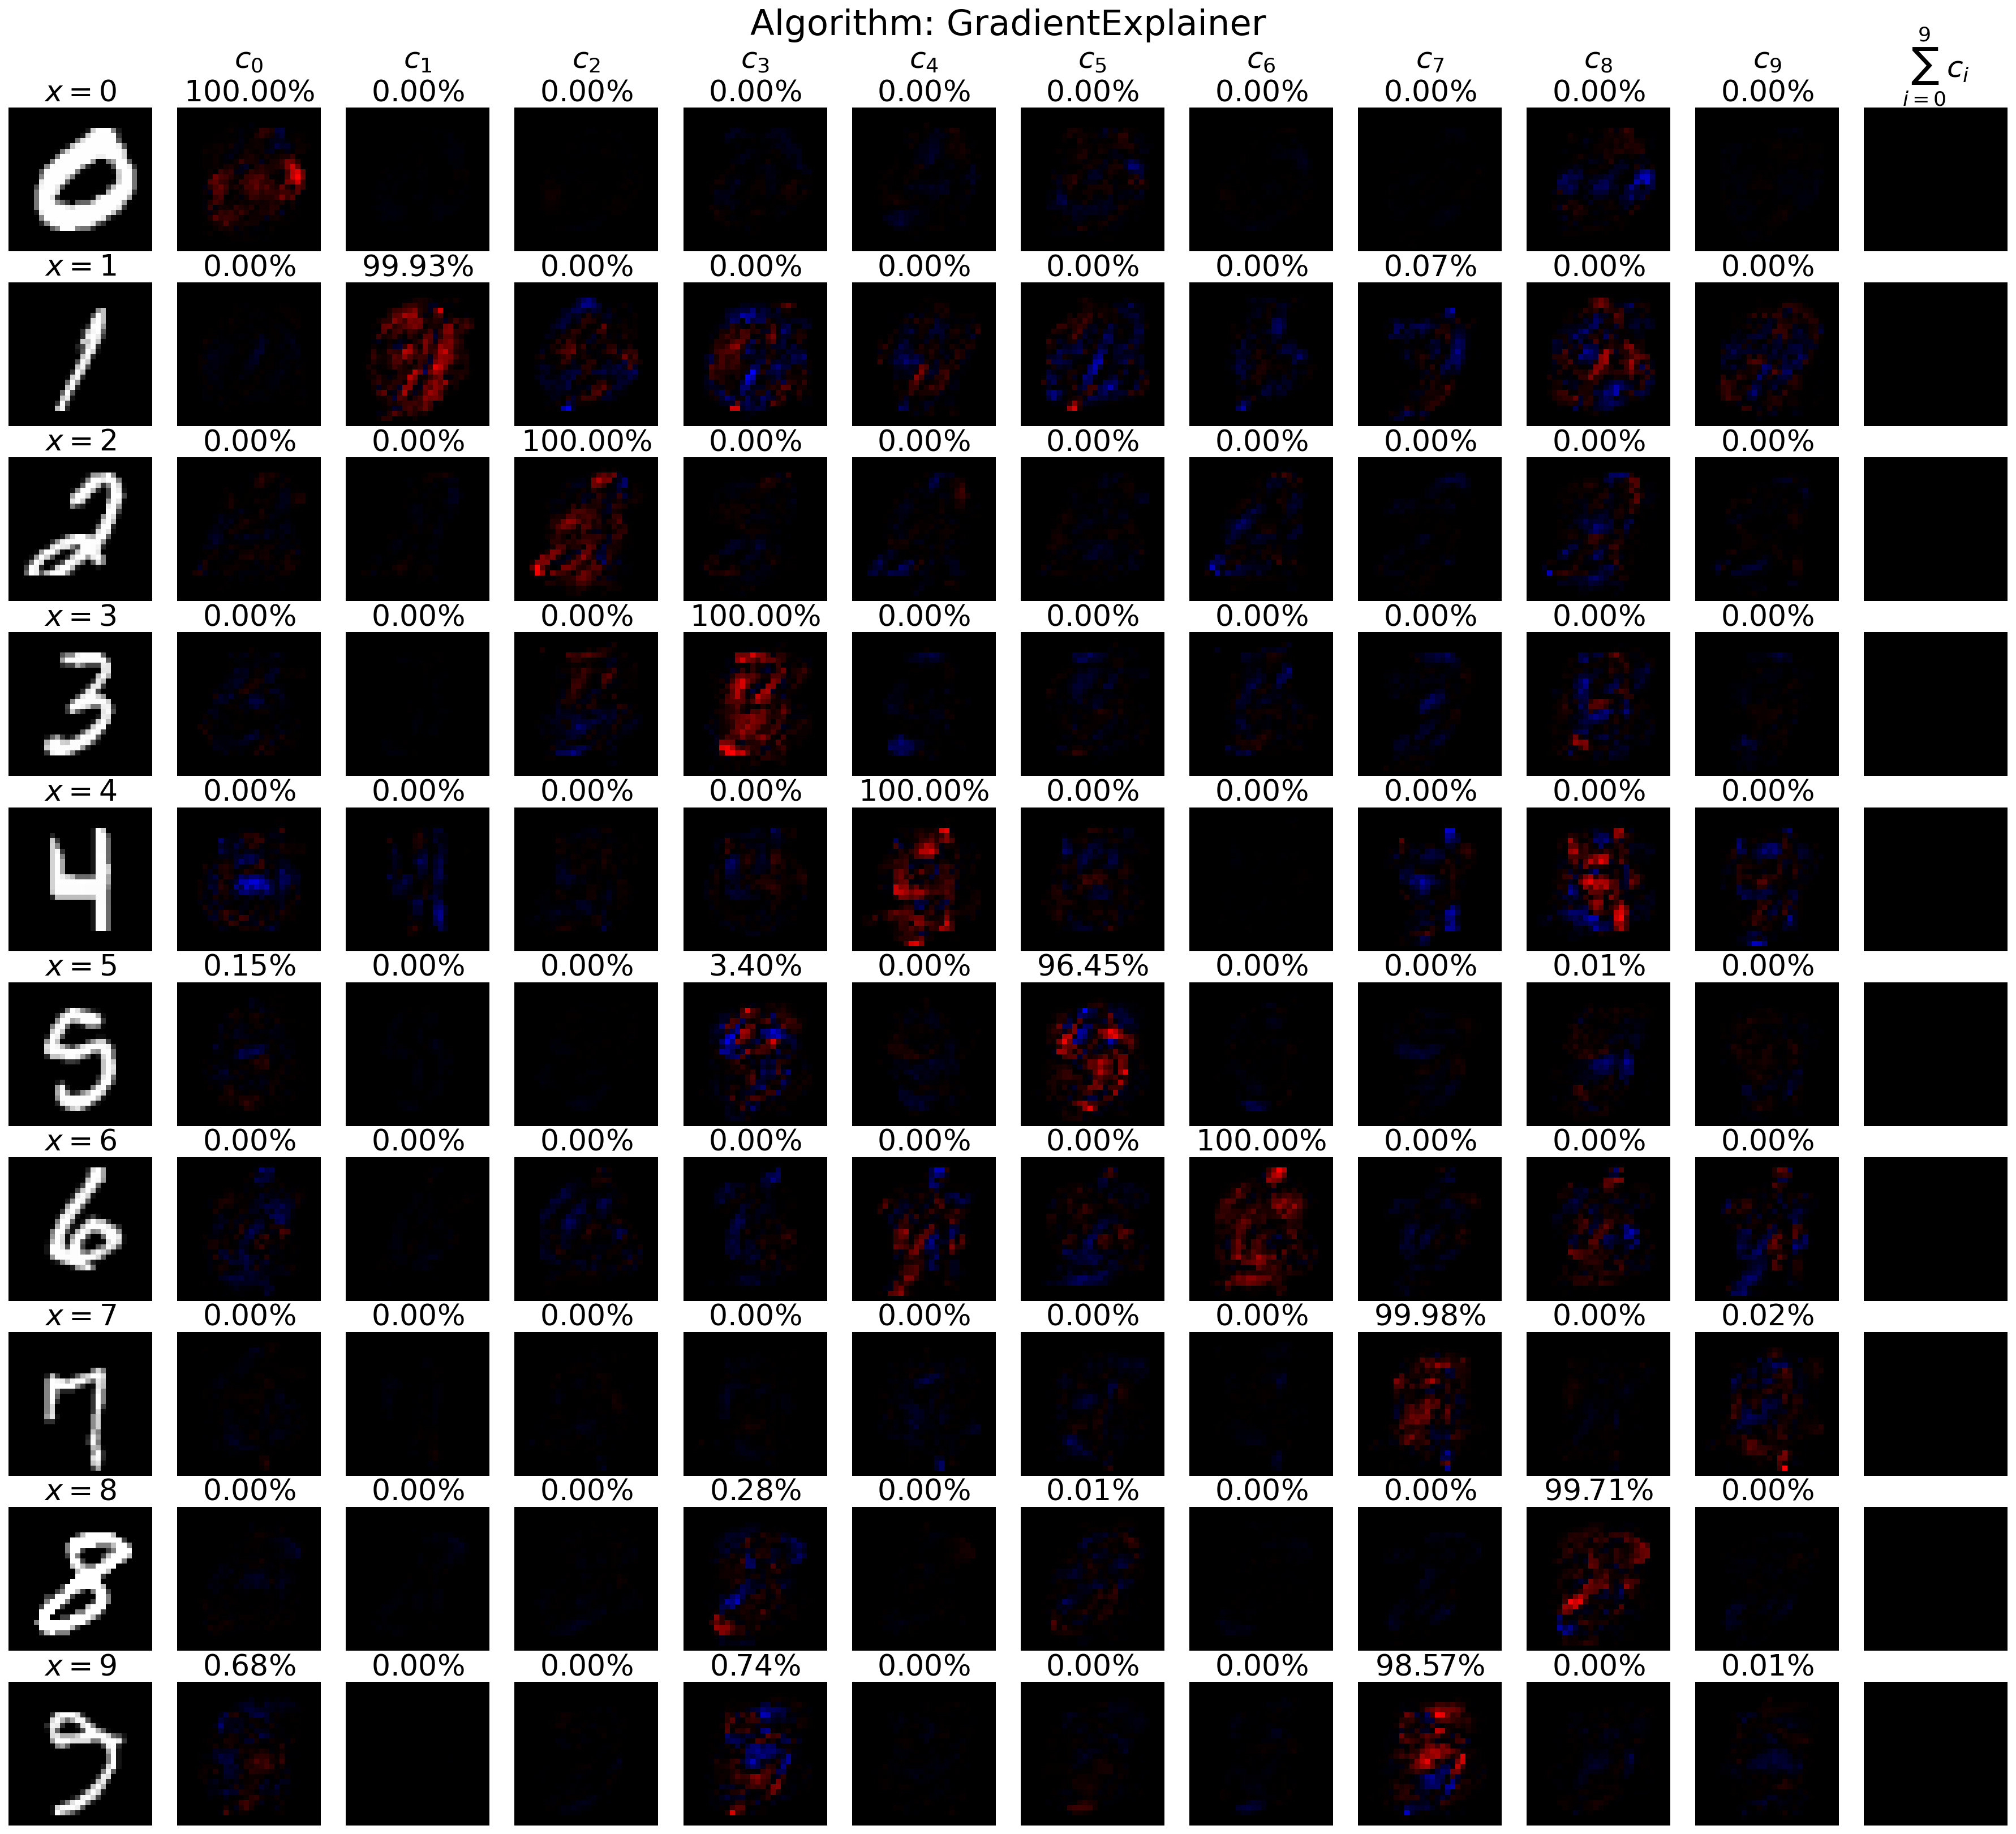

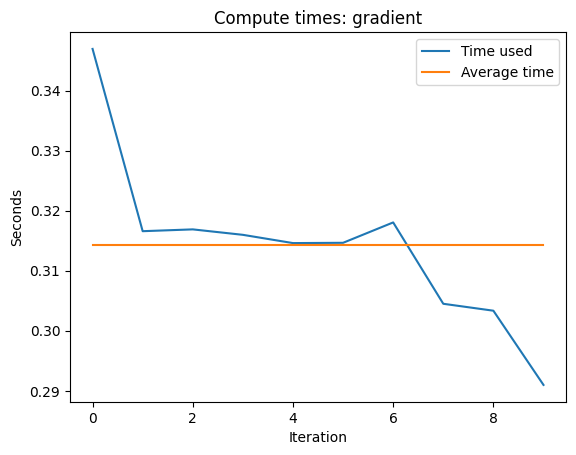

In [21]:
def mk_shap_latent_plot(algorithm: Explainers, evals: int):
    fig = plt.figure(dpi=150, figsize=(24,22)) 
    fig.suptitle(f"Algorithm: {algorithm.capitalize()}Explainer", size=30)

    def save_mnist(image: np.ndarray, path: str, **args) -> None:
        plt.imsave(path, image.repeat(16,0).repeat(16,1), **args)

    compute_times = []
    classifier = mnist.autoencoder.encoder + mnist.classifier_head

    with tqdm(total=rows, desc=f"{algorithm.capitalize()}Explainer") as bar:
        for row in range(rows):
            slot = row*columns

            sample,label = samples[row]
            sample = sample.numpy(force=True)
            label = int(label.item())
            predict = mnist(sample)
            probabilities = predict.classification().tolist()

            classification_explanation = classifier(sample).explain(algorithm, mnist.val_data, max_evals=evals)
            shap_values = classification_explanation.shap_values
            shap_sum: np.ndarray = shap_values.sum(0)
            norm = max([np.max(np.abs(shap_values)), np.max(np.abs(shap_sum))])


            compute_times.append(classification_explanation.compute_time.seconds().float())

            fig.add_subplot(rows,columns,slot+1)
            plt.imshow(sample, cmap="gray")
            plt.axis('off')
            plt.title(f"$x={{{label}}}$", size=25)
            save_mnist(sample, f"{save_folder}/{algorithm}/sample{row}.png", cmap="gray")
            

            for j,shap in enumerate(shap_values):
                fig.add_subplot(rows,columns,slot+j+2)
                im = np.zeros((28,28,3), dtype=np.float32)
                red = np.where(shap > 0, shap/norm, np.zeros_like(shap))
                blue = np.where(shap < 0, -shap/norm, np.zeros_like(shap))
                im[:,:,0] = red
                im[:,:,2] = blue
                plt.imshow(im)
                plt.axis('off')
                if row == 0:
                    plt.title(f"$c_{j}$\n${probabilities[j]*100:.2f}$%", size=25)
                else:
                    plt.title(f"${probabilities[j]*100:.2f}$%", size=25)
                save_mnist(im, f"{save_folder}/{algorithm}/vanilla{j}-explanation.png")
            
            bar.update()

            im = np.zeros((28,28,3), dtype=np.float32)
            red = np.where(shap_sum > 0, shap_sum/norm, np.zeros_like(shap_sum))
            blue = np.where(shap_sum < 0, -shap_sum/norm, np.zeros_like(shap_sum))
            im[:,:,0] = red
            im[:,:,2] = blue
            fig.add_subplot(rows,columns,slot+j+3)
            plt.imshow(im)
            plt.axis('off')
            if row == 0:
                plt.title(f"$\sum_{{i=0}}^{{9}}c_i$", size=25)
            save_mnist(im, f"{save_folder}/{algorithm}/vanilla-sum{row}.png")


    fig.tight_layout()
    fig.savefig(f"{save_folder}/{algorithm}/classification-{algorithm}-explanation.png", bbox_inches="tight")

    plt.figure()
    plt.plot(range(len(compute_times)), compute_times, label="Time used")
    plt.plot(range(len(compute_times)), [sum(compute_times)/len(compute_times)]*len(compute_times), label="Average time")
    plt.legend()
    plt.ylabel("Seconds")
    plt.xlabel("Iteration")
    plt.title(f"Compute times: {algorithm}")
    plt.savefig(f"{save_folder}/{algorithm}/compute-times.png")


algorithm: Explainers
for algorithm, evals in algorithms:
    mk_shap_latent_plot(algorithm, evals)